# TA-Lib Candlestick Scanner + Backtester (Swing Trading) — v3 (patched)

This version keeps the **full backtester** and fixes the **scanner** to:
- pick the **most recent** valid pattern inside `recent_window` across *all* patterns,
- apply the **trend filter at the bar where the signal occurred**,
- include **Pattern Time** in the scan table/CSV for chart verification.

Backtester still logs: `qty`, `pattern`, and `signal_time` for each trade.


## 1) Setup

In [106]:
import sys, subprocess, importlib

def ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
        print(f"OK: {pkg}")
    except ImportError:
        name = pip_name or pkg
        print(f"Installing {name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])

for p in ["yfinance", "pandas", "numpy", "matplotlib"]:
    ensure(p)

# TA-Lib
try:
    import talib as ta
    print("OK: TA-Lib available")
except Exception:
    print("TA-Lib not found, attempting pip install...")
    ensure("talib", "TA-Lib")
    import talib as ta

import pandas as pd
import numpy as np
import yfinance as yf
import math
import json
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 160)

OK: yfinance
OK: pandas
OK: numpy
OK: matplotlib
OK: TA-Lib available


## 2) Parameters

In [107]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# SYMBOLS & TIMEFRAME
symbols = ['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'ACMESOLAR.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AWL.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABREL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFCONS.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'AKUMS.NS', 'APLLTD.NS', 'ALIVUS.NS', 'ALKEM.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AIIL.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BAJAJHFL.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BERGEPAINT.NS', 'BDL.NS', 'BEL.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BHARTIHEXA.NS', 'BIKAJI.NS', 'BIOCON.NS', 'BSOFT.NS', 'BLUEDART.NS', 'BLUESTARCO.NS', 'BBTC.NS', 'BOSCHLTD.NS', 'FIRSTCRY.NS', 'BRIGADE.NS', 'BRITANNIA.NS', 'MAPMYINDIA.NS', 'CCL.NS', 'CESC.NS', 'CGPOWER.NS', 'CRISIL.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CANBK.NS', 'CAPLIPOINT.NS', 'CGCL.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYPLY.NS', 'CERA.NS', 'CHALET.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'CHOLAHLDNG.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'CUB.NS', 'CLEAN.NS', 'COALINDIA.NS', 'COCHINSHIP.NS', 'COFORGE.NS', 'COHANCE.NS', 'COLPAL.NS', 'CAMS.NS', 'CONCORDBIO.NS', 'CONCOR.NS', 'COROMANDEL.NS', 'CRAFTSMAN.NS', 'CREDITACC.NS', 'CROMPTON.NS', 'CUMMINSIND.NS', 'CYIENT.NS', 'DCMSHRIRAM.NS', 'DLF.NS', 'DOMS.NS', 'DABUR.NS', 'DALBHARAT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'DEEPAKNTR.NS', 'DELHIVERY.NS', 'DEVYANI.NS', 'DIVISLAB.NS', 'DIXON.NS', 'LALPATHLAB.NS', 'DRREDDY.NS', 'EIDPARRY.NS', 'EIHOTEL.NS', 'EICHERMOT.NS', 'ELECON.NS', 'ELGIEQUIP.NS', 'EMAMILTD.NS', 'EMCURE.NS', 'ENDURANCE.NS', 'ENGINERSIN.NS', 'ERIS.NS', 'ESCORTS.NS', 'ETERNAL.NS', 'EXIDEIND.NS', 'NYKAA.NS', 'FEDERALBNK.NS', 'FACT.NS', 'FINCABLES.NS', 'FINPIPE.NS', 'FSL.NS', 'FIVESTAR.NS', 'FORTIS.NS', 'GAIL.NS', 'GVT&D.NS', 'GMRAIRPORT.NS', 'GRSE.NS', 'GICRE.NS', 'GILLETTE.NS', 'GLAND.NS', 'GLAXO.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GODIGIT.NS', 'GPIL.NS', 'GODFRYPHLP.NS', 'GODREJAGRO.NS', 'GODREJCP.NS', 'GODREJIND.NS', 'GODREJPROP.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GRASIM.NS', 'GRAVITA.NS', 'GESHIP.NS', 'FLUOROCHEM.NS', 'GUJGASLTD.NS', 'GMDCLTD.NS', 'GNFC.NS', 'GPPL.NS', 'GSPL.NS', 'HEG.NS', 'HBLENGINE.NS', 'HCLTECH.NS', 'HDFCAMC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HSCL.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDCOPPER.NS', 'HINDPETRO.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'POWERINDIA.NS', 'HOMEFIRST.NS', 'HONASA.NS', 'HONAUT.NS', 'HUDCO.NS', 'HYUNDAI.NS', 'ICICIBANK.NS', 'ICICIGI.NS', 'ICICIPRULI.NS', 'IDBI.NS', 'IDFCFIRSTB.NS', 'IFCI.NS', 'IIFL.NS', 'INOXINDIA.NS', 'IRB.NS', 'IRCON.NS', 'ITC.NS', 'ITI.NS', 'INDGN.NS', 'INDIACEM.NS', 'INDIAMART.NS', 'INDIANB.NS', 'IEX.NS', 'INDHOTEL.NS', 'IOC.NS', 'IOB.NS', 'IRCTC.NS', 'IRFC.NS', 'IREDA.NS', 'IGL.NS', 'INDUSTOWER.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INOXWIND.NS', 'INTELLECT.NS', 'INDIGO.NS', 'IGIL.NS', 'IKS.NS', 'IPCALAB.NS', 'JBCHEPHARM.NS', 'JKCEMENT.NS', 'JBMA.NS', 'JKTYRE.NS', 'JMFINANCIL.NS', 'JSWENERGY.NS', 'JSWHL.NS', 'JSWINFRA.NS', 'JSWSTEEL.NS', 'JPPOWER.NS', 'J&KBANK.NS', 'JINDALSAW.NS', 'JSL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'JUBLFOOD.NS', 'JUBLINGREA.NS', 'JUBLPHARMA.NS', 'JWL.NS', 'JUSTDIAL.NS', 'JYOTHYLAB.NS', 'JYOTICNC.NS', 'KPRMILL.NS', 'KEI.NS', 'KNRCON.NS', 'KPITTECH.NS', 'KAJARIACER.NS', 'KPIL.NS', 'KALYANKJIL.NS', 'KANSAINER.NS', 'KARURVYSYA.NS', 'KAYNES.NS', 'KEC.NS', 'KFINTECH.NS', 'KIRLOSBROS.NS', 'KIRLOSENG.NS', 'KOTAKBANK.NS', 'KIMS.NS', 'LTF.NS', 'LTTS.NS', 'LICHSGFIN.NS', 'LTFOODS.NS', 'LTIM.NS', 'LT.NS', 'LATENTVIEW.NS', 'LAURUSLABS.NS', 'LEMONTREE.NS', 'LICI.NS', 'LINDEINDIA.NS', 'LLOYDSME.NS', 'LODHA.NS', 'LUPIN.NS', 'MMTC.NS', 'MRF.NS', 'MGL.NS', 'MAHSEAMLES.NS', 'M&MFIN.NS', 'M&M.NS', 'MANAPPURAM.NS', 'MRPL.NS', 'MANKIND.NS', 'MARICO.NS', 'MARUTI.NS', 'MASTEK.NS', 'MFSL.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'METROPOLIS.NS', 'MINDACORP.NS', 'MSUMI.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MCX.NS', 'MUTHOOTFIN.NS', 'NATCOPHARM.NS', 'NBCC.NS', 'NCC.NS', 'NHPC.NS', 'NLCINDIA.NS', 'NMDC.NS', 'NSLNISP.NS', 'NTPCGREEN.NS', 'NTPC.NS', 'NH.NS', 'NATIONALUM.NS', 'NAVA.NS', 'NAVINFLUOR.NS', 'NESTLEIND.NS', 'NETWEB.NS', 'NETWORK18.NS', 'NEULANDLAB.NS', 'NEWGEN.NS', 'NAM-INDIA.NS', 'NIVABUPA.NS', 'NUVAMA.NS', 'OBEROIRLTY.NS', 'ONGC.NS', 'OIL.NS', 'OLAELEC.NS', 'OLECTRA.NS', 'PAYTM.NS', 'OFSS.NS', 'POLICYBZR.NS', 'PCBL.NS', 'PGEL.NS', 'PIIND.NS', 'PNBHOUSING.NS', 'PNCINFRA.NS', 'PTCIL.NS', 'PVRINOX.NS', 'PAGEIND.NS', 'PATANJALI.NS', 'PERSISTENT.NS', 'PETRONET.NS', 'PFIZER.NS', 'PHOENIXLTD.NS', 'PIDILITIND.NS', 'PEL.NS', 'PPLPHARMA.NS', 'POLYMED.NS', 'POLYCAB.NS', 'POONAWALLA.NS', 'PFC.NS', 'POWERGRID.NS', 'PRAJIND.NS', 'PREMIERENE.NS', 'PRESTIGE.NS', 'PNB.NS', 'RRKABEL.NS', 'RBLBANK.NS', 'RECLTD.NS', 'RHIM.NS', 'RITES.NS', 'RADICO.NS', 'RVNL.NS', 'RAILTEL.NS', 'RAINBOW.NS', 'RKFORGE.NS', 'RCF.NS', 'RTNINDIA.NS', 'RAYMONDLSL.NS', 'RAYMOND.NS', 'REDINGTON.NS', 'RELIANCE.NS', 'RPOWER.NS', 'ROUTE.NS', 'SBFC.NS', 'SBICARD.NS', 'SBILIFE.NS', 'SJVN.NS', 'SKFINDIA.NS', 'SRF.NS', 'SAGILITY.NS', 'SAILIFE.NS', 'SAMMAANCAP.NS', 'MOTHERSON.NS', 'SAPPHIRE.NS', 'SARDAEN.NS', 'SAREGAMA.NS', 'SCHAEFFLER.NS', 'SCHNEIDER.NS', 'SCI.NS', 'SHREECEM.NS', 'RENUKA.NS', 'SHRIRAMFIN.NS', 'SHYAMMETL.NS', 'SIEMENS.NS', 'SIGNATURE.NS', 'SOBHA.NS', 'SOLARINDS.NS', 'SONACOMS.NS', 'SONATSOFTW.NS', 'STARHEALTH.NS', 'SBIN.NS', 'SAIL.NS', 'SWSOLAR.NS', 'SUMICHEM.NS', 'SUNPHARMA.NS', 'SUNTV.NS', 'SUNDARMFIN.NS', 'SUNDRMFAST.NS', 'SUPREMEIND.NS', 'SUZLON.NS', 'SWANCORP.NS', 'SWIGGY.NS', 'SYNGENE.NS', 'SYRMA.NS', 'TBOTEK.NS', 'TVSMOTOR.NS', 'TANLA.NS', 'TATACHEM.NS', 'TATACOMM.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAELXSI.NS', 'TATAINVEST.NS', 'TATAMOTORS.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TATATECH.NS', 'TTML.NS', 'TECHM.NS', 'TECHNOE.NS', 'TEJASNET.NS', 'NIACL.NS', 'RAMCOCEM.NS', 'THERMAX.NS', 'TIMKEN.NS', 'TITAGARH.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TORNTPOWER.NS', 'TARIL.NS', 'TRENT.NS', 'TRIDENT.NS', 'TRIVENI.NS', 'TRITURBINE.NS', 'TIINDIA.NS', 'UCOBANK.NS', 'UNOMINDA.NS', 'UPL.NS', 'UTIAMC.NS', 'ULTRACEMCO.NS', 'UNIONBANK.NS', 'UBL.NS', 'UNITDSPR.NS', 'USHAMART.NS', 'VGUARD.NS', 'DBREALTY.NS', 'VTL.NS', 'VBL.NS', 'MANYAVAR.NS', 'VEDL.NS', 'VIJAYA.NS', 'VMM.NS', 'IDEA.NS', 'VOLTAS.NS', 'WAAREEENER.NS', 'WELCORP.NS', 'WELSPUNLIV.NS', 'WESTLIFE.NS', 'WHIRLPOOL.NS', 'WIPRO.NS', 'WOCKPHARMA.NS', 'YESBANK.NS', 'ZFCVINDIA.NS', 'ZEEL.NS', 'ZENTEC.NS', 'ZENSARTECH.NS', 'ZYDUSLIFE.NS', 'ECLERX.NS']

timeframe = "1d"              # '1d' (Daily) or '4h' (4-Hour)
lookback_days = 1825          # For daily only (approx 5 years)

# SCANNER
recent_window = 3             # Look for signals in the last N candles
use_trend_filter_scanner = True  # Bullish only after downtrend, bearish only after uptrend

# BACKTEST
signal_set = "bullish"        # 'bullish', 'bearish', or 'both'
use_trend_filter_backtest = True
allow_shorts = False          # For equities, default long-only

# ATR risk model
atr_period = 14
atr_sl_mult = 2.0             # Stop distance = SL mult * ATR
atr_tp_mult = 2.0             # Take profit distance = TP mult * ATR

# Portfolio & trading
initial_equity = 100000.0
risk_per_trade_pct = 1.0      # % of equity allocated per trade (simple sizing)
fees_bps_per_side = 10.0      # 10 bps = 0.10% per side
slippage_bps_per_side = 5.0   # 5 bps = 0.05% per side
max_holding_bars = 20         # Time stop if neither SL nor TP is hit
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

assert timeframe in ("1d", "4h")
assert signal_set in ("bullish", "bearish", "both")

## 3) Helpers

In [108]:
def yf_params(timeframe: str, lookback_days: int):
    if timeframe == "1d":
        period = f"{min(max(lookback_days, 2), 3650)}d"  # up to 10y
        interval = "1d"
    else:
        period = "60d"   # yfinance intraday reliable max for 4H
        interval = "4h"
    return dict(period=period, interval=interval)

def fetch_ohlc(ticker: str, period: str, interval: str) -> pd.DataFrame:
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=False, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs(ticker, axis=1, level=1)
        except Exception:
            pass
    df = df.rename(columns={c: c.title() for c in df.columns})
    df = df.dropna()
    return df

def series_slope(series: pd.Series, window: int = 5) -> pd.Series:
    return series.rolling(window).apply(lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)

def in_downtrend_series(df: pd.DataFrame, window: int = 5) -> pd.Series:
    close = df['Close']
    sma20 = close.rolling(20).mean()
    sl = series_slope(close, window)
    return (sl < 0) & (close < sma20)

def in_uptrend_series(df: pd.DataFrame, window: int = 5) -> pd.Series:
    close = df['Close']
    sma20 = close.rolling(20).mean()
    sl = series_slope(close, window)
    return (sl > 0) & (close > sma20)

## 4) TA-Lib Pattern Signals

In [109]:
import talib as ta

BULLISH_NAMES = ["Bullish Engulfing","Morning Star","Hammer","Piercing Line","Three White Soldiers","Bullish Harami"]
BEARISH_NAMES = ["Bearish Engulfing","Evening Star","Shooting Star","Dark Cloud Cover","Three Black Crows","Bearish Harami"]

PATTERN_CONTEXT = {
    "Bullish Engulfing": "End of a downtrend; second candle's body engulfs prior body — bullish reversal potential.",
    "Morning Star": "Downtrend: red, small 'star', strong green — reversal.",
    "Hammer": "Downtrend: long lower shadow rejects lows — reversal potential.",
    "Piercing Line": "Downtrend: gap-down then close above prior midpoint — reversal.",
    "Three White Soldiers": "Three strong advances after weakness — bullish continuation/reversal.",
    "Bullish Harami": "Downtrend: small green within a large red — reversal potential.",
    "Bearish Engulfing": "Uptrend: large red engulfs prior body — bearish reversal potential.",
    "Evening Star": "Uptrend: green, small 'star', strong red — reversal.",
    "Shooting Star": "Uptrend: long upper shadow rejects highs — reversal potential.",
    "Dark Cloud Cover": "Uptrend: gap-up then close below prior midpoint — reversal.",
    "Three Black Crows": "Three strong declines after strength — bearish continuation/reversal.",
    "Bearish Harami": "Uptrend: small red within a large green — reversal potential.",
}

import pandas as pd
import numpy as np

def talib_signals(df: pd.DataFrame) -> pd.DataFrame:
    o = df['Open'].values.astype(float)
    h = df['High'].values.astype(float)
    l = df['Low'].values.astype(float)
    c = df['Close'].values.astype(float)

    out = {}
    out["Bullish Engulfing"] = ta.CDLENGULFING(o,h,l,c)
    out["Bearish Engulfing"] = out["Bullish Engulfing"]  # same func; sign distinguishes

    out["Morning Star"] = ta.CDLMORNINGSTAR(o,h,l,c)
    out["Evening Star"] = ta.CDLEVENINGSTAR(o,h,l,c)

    out["Hammer"] = ta.CDLHAMMER(o,h,l,c)
    out["Shooting Star"] = ta.CDLSHOOTINGSTAR(o,h,l,c)

    out["Piercing Line"] = ta.CDLPIERCING(o,h,l,c)
    out["Dark Cloud Cover"] = ta.CDLDARKCLOUDCOVER(o,h,l,c)

    out["Three White Soldiers"] = ta.CDL3WHITESOLDIERS(o,h,l,c)
    out["Three Black Crows"]   = ta.CDL3BLACKCROWS(o,h,l,c)

    out["Bullish Harami"] = ta.CDLHARAMI(o,h,l,c)
    out["Bearish Harami"] = out["Bullish Harami"]

    sig = pd.DataFrame(out, index=df.index)
    for col in sig.columns:
        sig[col] = np.where(sig[col] > 0, 1, np.where(sig[col] < 0, -1, 0))
    return sig

def combined_signal(df: pd.DataFrame, sig: pd.DataFrame, use_trend=True, choose="both") -> pd.Series:
    bull = pd.Series(0, index=df.index)
    bear = pd.Series(0, index=df.index)

    if choose in ("bullish","both"):
        bull_series = pd.Series(0, index=df.index)
        for name in BULLISH_NAMES:
            s = sig[name]
            if name == "Bullish Harami":
                s = (sig["Bullish Harami"] > 0).astype(int)
            elif name == "Bullish Engulfing":
                s = (sig["Bullish Engulfing"] > 0).astype(int)
            else:
                s = (s > 0).astype(int)
            bull_series = bull_series | (s == 1)
        if use_trend:
            down = in_downtrend_series(df)
            bull = ((bull_series == 1) & down.fillna(False)).astype(int)
        else:
            bull = (bull_series == 1).astype(int)

    if choose in ("bearish","both"):
        bear_series = pd.Series(0, index=df.index)
        for name in BEARISH_NAMES:
            s = sig[name]
            if name == "Bearish Harami":
                s = (sig["Bearish Harami"] < 0).astype(int)
            elif name == "Bearish Engulfing":
                s = (sig["Bearish Engulfing"] < 0).astype(int)
            else:
                s = (s < 0).astype(int)
            bear_series = bear_series | (s == 1)
        if use_trend:
            up = in_uptrend_series(df)
            bear = ((bear_series == 1) & up.fillna(False)).astype(int) * -1
        else:
            bear = (bear_series == 1).astype(int) * -1

    return bull.add(bear, fill_value=0).astype(int)  # +1, -1, or 0

def pattern_name_on_bar(df: pd.DataFrame, sig_all: pd.DataFrame, i: int, choose="both", use_trend=True):
    """Return a pattern name that fired on bar i (respecting side & trend). Priority: list order."""
    if i < 0 or i >= len(sig_all):
        return None
    if choose in ("bullish","both"):
        if not use_trend or in_downtrend_series(df).iloc[i]:
            for name in BULLISH_NAMES:
                val = sig_all[name].iloc[i]
                if name == "Bullish Harami":
                    ok = val > 0
                elif name == "Bullish Engulfing":
                    ok = sig_all["Bullish Engulfing"].iloc[i] > 0
                else:
                    ok = val > 0
                if ok:
                    return name
    if choose in ("bearish","both"):
        if not use_trend or in_uptrend_series(df).iloc[i]:
            for name in BEARISH_NAMES:
                val = sig_all[name].iloc[i]
                if name == "Bearish Harami":
                    ok = val < 0
                elif name == "Bearish Engulfing":
                    ok = sig_all["Bearish Engulfing"].iloc[i] < 0
                else:
                    ok = val < 0
                if ok:
                    return name
    return None

## 5) Scanner (patched)

In [110]:
def find_latest_signal(df: pd.DataFrame, recent_window: int = 3, use_trend=True):
    if len(df) < 30:
        return None

    sig_all = talib_signals(df)

    # Trend series aligned to df
    down = in_downtrend_series(df).fillna(False)
    up = in_uptrend_series(df).fillna(False)

    start = max(0, len(df) - recent_window)
    best = None  # dict with pattern, side, index

    # Search **all** patterns, keep the most recent valid bar
    for name in (BULLISH_NAMES + BEARISH_NAMES):
        vals = sig_all[name].values
        for i in range(len(vals)-1, start-1, -1):
            v = vals[i]
            if v == 0:
                continue
            side = "Bullish" if name in BULLISH_NAMES else "Bearish"
            # Harami sign check
            if name == "Bullish Harami" and v < 0: 
                continue
            if name == "Bearish Harami" and v > 0: 
                continue
            # Trend filter at the **signal bar**
            if use_trend:
                if side == "Bullish" and not bool(down.iloc[i]):
                    continue
                if side == "Bearish" and not bool(up.iloc[i]):
                    continue
            if (best is None) or (i > best['index']):
                best = dict(pattern=name, side=side, index=i, time=df.index[i], context=PATTERN_CONTEXT[name])
    return best

def run_scanner(symbols, timeframe, lookback_days, recent_window, use_trend):
    yfp = yf_params(timeframe, lookback_days)
    rows = []
    for sym in symbols:
        try:
            df = fetch_ohlc(sym, **yfp)
            if df.empty:
                rows.append(dict(symbol=sym, pattern="No clear setup", side="", pattern_time="", context="No data"))
                continue
            sig = find_latest_signal(df, recent_window=recent_window, use_trend=use_trend)
            if sig is None:
                rows.append(dict(symbol=sym, pattern="No clear setup", side="", pattern_time="", context="—"))
            else:
                rows.append(dict(symbol=sym, pattern=sig['pattern'], side=sig['side'], pattern_time=str(sig['time']), context=sig['context']))
        except Exception as e:
            rows.append(dict(symbol=sym, pattern="Error", side="", pattern_time="", context=str(e)))
    res = pd.DataFrame(rows, columns=["symbol","pattern","side","pattern_time","context"])
    return res

scan_results = run_scanner(symbols, timeframe, lookback_days, recent_window, use_trend_filter_scanner)
scan_results = scan_results.rename(columns={
    "symbol":"Stock Symbol",
    "pattern":"Pattern Detected",
    "side":"Bullish/Bearish",
    "pattern_time":"Pattern Time",
    "context":"When this pattern usually forms"
})
scan_results

,Stock Symbol,Pattern Detected,Bullish/Bearish,Pattern Time,When this pattern usually forms
0,360ONE.NS,Bullish Engulfing,Bullish,2025-09-03 00:00:00,End of a downtrend; second candle's body engul...
1,3MINDIA.NS,No clear setup,,,—
2,ABB.NS,Dark Cloud Cover,Bearish,2025-09-04 00:00:00,Uptrend: gap-up then close below prior midpoin...
3,ACC.NS,No clear setup,,,—
4,ACMESOLAR.NS,No clear setup,,,—
...,...,...,...,...,...
495,ZEEL.NS,Bullish Engulfing,Bullish,2025-09-04 00:00:00,End of a downtrend; second candle's body engul...
496,ZENTEC.NS,No clear setup,,,—
497,ZENSARTECH.NS,No clear setup,,,—
498,ZYDUSLIFE.NS,No clear setup,,,—


In [111]:
# Save scan results with Pattern Time
scan_csv = f"talib_candlestick_scan_{timeframe}.csv"
scan_results.to_csv(scan_csv, index=False)
print(f"Saved scan CSV: {scan_csv}")

bullish_list = scan_results[scan_results["Bullish/Bearish"]=="Bullish"]["Stock Symbol"].tolist()
bearish_list = scan_results[scan_results["Bullish/Bearish"]=="Bearish"]["Stock Symbol"].tolist()

print("\nScanner Summary:")
print("• Bullish swing candidates:", ", ".join(bullish_list) if bullish_list else "None")
print("• Bearish / avoid for now:", ", ".join(bearish_list) if bearish_list else "None")

Saved scan CSV: talib_candlestick_scan_1d.csv

Scanner Summary:
• Bullish swing candidates: 360ONE.NS, AUBANK.NS, ADANIGREEN.NS, ABSLAMC.NS, ALIVUS.NS, AXISBANK.NS, BAJAJHFL.NS, BANKBARODA.NS, BHEL.NS, BLUEDART.NS, CRISIL.NS, CHOLAHLDNG.NS, CLEAN.NS, CONCORDBIO.NS, COROMANDEL.NS, CRAFTSMAN.NS, DATAPATTNS.NS, DEEPAKNTR.NS, EIDPARRY.NS, ELECON.NS, EMCURE.NS, FEDERALBNK.NS, FIVESTAR.NS, GVT&D.NS, GRSE.NS, GICRE.NS, GODFRYPHLP.NS, GODREJIND.NS, FLUOROCHEM.NS, GPPL.NS, HDFCLIFE.NS, HFCL.NS, POWERINDIA.NS, IFCI.NS, IIFL.NS, INDIANB.NS, NAUKRI.NS, JBMA.NS, J&KBANK.NS, JIOFIN.NS, JYOTICNC.NS, KALYANKJIL.NS, KARURVYSYA.NS, LICHSGFIN.NS, LT.NS, LODHA.NS, MFSL.NS, MAXHEALTH.NS, MOTILALOFS.NS, NATCOPHARM.NS, OIL.NS, PFIZER.NS, PEL.NS, PRAJIND.NS, PRESTIGE.NS, RHIM.NS, REDINGTON.NS, ROUTE.NS, SBICARD.NS, SBILIFE.NS, SJVN.NS, SAPPHIRE.NS, SARDAEN.NS, SCHAEFFLER.NS, SOBHA.NS, SONACOMS.NS, SUNPHARMA.NS, SUZLON.NS, TATACONSUM.NS, TATAINVEST.NS, TIMKEN.NS, UNIONBANK.NS, VTL.NS, MANYAVAR.NS, VMM.NS, WELC

## 6) Backtester (qty + pattern + signal_time)

In [112]:
def compute_atr(df: pd.DataFrame, period=14) -> pd.Series:
    o = df['Open'].values.astype(float)
    h = df['High'].values.astype(float)
    l = df['Low'].values.astype(float)
    c = df['Close'].values.astype(float)
    atr = ta.ATR(h, l, c, timeperiod=period)
    return pd.Series(atr, index=df.index)

def bps_to_mult(bps: float) -> float:
    return 1.0 + (bps/10000.0)

def first_touch_exit(o, h, l, c, long: bool, stop, target):
    # Return (exit_price, reason) considering bar sequence: open -> high/low -> close
    if long:
        if o <= stop:  # gap below stop
            return float(o), "gap_stop"
        hit_target = h >= target
        hit_stop = l <= stop
        if hit_target and hit_stop:
            return float(stop), "stop"
        if hit_target:
            return float(target), "target"
        if hit_stop:
            return float(stop), "stop"
        return None, None
    else:
        if o >= stop:  # gap above stop
            return float(o), "gap_stop"
        hit_target = l <= target
        hit_stop = h >= stop
        if hit_target and hit_stop:
            return float(stop), "stop"
        if hit_target:
            return float(target), "target"
        if hit_stop:
            return float(stop), "stop"
        return None, None

def backtest_symbol(df: pd.DataFrame, signals: pd.Series, sig_all: pd.DataFrame, params: dict):
    atr = compute_atr(df, period=params['atr_period'])
    trades = []
    equity = params['initial_equity']
    idx_list = list(df.index)
    position = None

    for i in range(len(df)-1):  # evaluate next bar for fills
        ts = idx_list[i]
        nxt_ts = idx_list[i+1]
        nxt = df.loc[nxt_ts]

        # Manage open position
        if position is not None:
            exit_px, reason = first_touch_exit(
                float(nxt['Open']), float(nxt['High']), float(nxt['Low']), float(nxt['Close']),
                long=(position['side'] == 1),
                stop=position['stop'], target=position['target']
            )
            exit_now = False
            if exit_px is not None:
                exit_now = True
            else:
                if (i+1 - position['entry_i']) >= params['max_holding_bars']:
                    exit_px = float(nxt['Close'])
                    reason = "time"
                    exit_now = True

            if exit_now:
                fee_mult = bps_to_mult(params['fees_bps_per_side'] + params['slippage_bps_per_side'])
                if position['side'] == 1:
                    gross = (exit_px / position['entry_fill']) - 1.0
                else:
                    gross = (position['entry_fill'] / exit_px) - 1.0
                gross = (gross + 1.0) / fee_mult - 1.0  # exit costs

                principal = position['qty'] * position['entry_fill']
                pnl = principal * gross
                equity += pnl

                trades.append({
                    "symbol": params['symbol'],
                    "signal_time": position['signal_time'],
                    "pattern": position['pattern'],
                    "entry_time": position['entry_time'],
                    "exit_time": nxt_ts,
                    "side": "LONG" if position['side']==1 else "SHORT",
                    "qty": position['qty'],
                    "entry_price": position['entry_fill'],
                    "exit_price": exit_px,
                    "reason": reason,
                    "bars": (i+1 - position['entry_i']),
                    "gross_ret_pct": gross*100.0,
                    "pnl": pnl,
                    "equity_after": equity
                })
                position = None

        # New entries
        if position is None:
            sig = int(signals.iloc[i])
            if sig == 0:
                continue

            atr_val = float(atr.iloc[i])
            if math.isnan(atr_val) or atr_val <= 0:
                continue

            entry_open = float(nxt['Open'])
            ent_fee_mult = bps_to_mult(params['fees_bps_per_side'] + params['slippage_bps_per_side'])

            pat_name = pattern_name_on_bar(df, sig_all, i, choose=params['signal_set'], use_trend=params['use_trend'])
            if pat_name is None:
                continue

            alloc = (params['risk_per_trade_pct'] / 100.0)
            if sig == 1:
                stop = entry_open - params['atr_sl_mult'] * atr_val
                target = entry_open + params['atr_tp_mult'] * atr_val
                entry_fill = entry_open * ent_fee_mult
                qty = math.floor((equity * alloc) / entry_fill)
                if qty < 1:
                    continue
                position = dict(
                    side=1, entry_i=i+1, entry_time=nxt_ts, entry_fill=entry_fill,
                    stop=stop, target=target, alloc=alloc, qty=qty,
                    signal_time=ts, pattern=pat_name
                )
            elif sig == -1 and params['allow_shorts']:
                stop = entry_open + params['atr_sl_mult'] * atr_val
                target = entry_open - params['atr_tp_mult'] * atr_val
                entry_fill = entry_open / ent_fee_mult  # short
                qty = math.floor((equity * alloc) / entry_fill)
                if qty < 1:
                    continue
                position = dict(
                    side=-1, entry_i=i+1, entry_time=nxt_ts, entry_fill=entry_fill,
                    stop=stop, target=target, alloc=alloc, qty=qty,
                    signal_time=ts, pattern=pat_name
                )

    return pd.DataFrame(trades), equity

def portfolio_backtest(data_map, signals_map, sig_all_map, params):
    all_trades = []
    per_symbol = {}
    for sym, df in data_map.items():
        lp = params.copy()
        lp['symbol'] = sym
        tdf, final_eq = backtest_symbol(df, signals_map[sym], sig_all_map[sym], lp)
        all_trades.append(tdf)
        per_symbol[sym] = dict(trades=tdf, final_equity=final_eq)
    trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(columns=[
        "symbol","signal_time","pattern","entry_time","exit_time","side","qty","entry_price","exit_price","reason","bars","gross_ret_pct","pnl","equity_after"
    ])
    return trades_df, per_symbol

## 7) Run Backtest

In [113]:
# Build data & global signals
yfp = yf_params(timeframe, lookback_days)
data_map, signals_map, sig_all_map = {}, {}, {}

for sym in symbols:
    df = fetch_ohlc(sym, **yfp)
    if df.empty or len(df) < 60:
        print(f"Skipping {sym}: insufficient data")
        continue
    sig_all = talib_signals(df)
    sig_comb = combined_signal(df, sig_all, use_trend=use_trend_filter_backtest, choose=signal_set)
    data_map[sym] = df
    signals_map[sym] = sig_comb
    sig_all_map[sym] = sig_all

params = dict(
    atr_period=atr_period,
    atr_sl_mult=atr_sl_mult,
    atr_tp_mult=atr_tp_mult,
    initial_equity=initial_equity / max(1, len(data_map)),  # equal split starting capital per symbol
    risk_per_trade_pct=risk_per_trade_pct,
    fees_bps_per_side=fees_bps_per_side,
    slippage_bps_per_side=slippage_bps_per_side,
    allow_shorts=allow_shorts,
    max_holding_bars=max_holding_bars,
    use_trend=use_trend_filter_backtest,
    signal_set=signal_set
)

trades_df, per_symbol_results = portfolio_backtest(data_map, signals_map, sig_all_map, params)

trades_csv = "bt_trades.csv"
trades_df.to_csv(trades_csv, index=False)
print(f"Saved trades: {trades_csv}")
trades_df.tail(10)


1 Failed download:
['DEVYANI.NS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Skipping DEVYANI.NS: insufficient data



1 Failed download:
['UBL.NS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Skipping UBL.NS: insufficient data



1 Failed download:
['VTL.NS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Skipping VTL.NS: insufficient data
Saved trades: bt_trades.csv


,symbol,signal_time,pattern,entry_time,exit_time,side,qty,entry_price,exit_price,reason,bars,gross_ret_pct,pnl,equity_after
12,JPPOWER.NS,2019-10-30,Hammer,2019-10-31,2019-11-29,LONG,1,1.101650,1.150000,time,20,4.232518,0.046628,201.014357
13,JPPOWER.NS,2020-05-28,Bullish Harami,2020-05-29,2020-06-03,LONG,2,0.851275,0.998530,target,3,17.122428,0.291518,201.305875
14,RTNINDIA.NS,2019-06-18,Hammer,2019-06-19,2019-07-03,LONG,1,1.902850,2.211357,target,10,16.038833,0.305195,201.512438
15,RTNINDIA.NS,2019-08-14,Bullish Harami,2019-08-16,2019-08-23,LONG,1,1.552325,1.168363,stop,5,-24.847366,-0.385712,201.126727
16,RTNINDIA.NS,2020-04-24,Bullish Harami,2020-04-27,2020-04-29,LONG,1,1.702550,1.550000,gap_stop,2,-9.096450,-0.154872,200.971855
17,RTNINDIA.NS,2020-05-04,Bullish Harami,2020-05-05,2020-05-28,LONG,1,1.502250,1.657088,target,16,10.141839,0.152356,201.124211
18,RPOWER.NS,2020-05-14,Bullish Harami,2020-05-15,2020-06-02,LONG,1,1.802700,1.951584,target,11,8.096824,0.145961,201.353205
19,SUZLON.NS,2019-12-12,Bullish Harami,2019-12-13,2020-01-03,LONG,1,1.931141,2.214394,target,14,14.495891,0.279936,201.487180
20,SUZLON.NS,2020-03-17,Bullish Harami,2020-03-18,2020-04-13,LONG,1,1.885162,2.210126,target,15,17.062406,0.321654,201.808834
21,TTML.NS,2020-03-26,Hammer,2020-03-27,2020-04-15,LONG,1,1.852775,2.184350,target,9,17.719523,0.328303,201.535546


## 8) Performance Metrics

In [114]:
def compute_metrics(trades: pd.DataFrame):
    if trades.empty:
        return {}
    rets = trades['gross_ret_pct'] / 100.0
    wins = rets[rets > 0]
    losses = rets[rets <= 0]

    win_rate = (len(wins) / len(rets)) if len(rets) else 0.0
    avg_win = wins.mean() if len(wins) else 0.0
    avg_loss = losses.mean() if len(losses) else 0.0
    profit_factor = (wins.sum() / abs(losses.sum())) if len(losses) else float('inf')
    expectancy = rets.mean()

    # Build a simple equity curve by compounding trade to trade in time order
    start_eq = (initial_equity / max(1, len(trades['symbol'].unique())))  # mirror per-symbol split
    eq = [start_eq]
    times = []
    for _, r in trades.sort_values('exit_time').iterrows():
        eq.append(eq[-1] * (1 + r['gross_ret_pct']/100.0))
        times.append(r['exit_time'])
    equity_series = pd.Series(eq[1:], index=pd.to_datetime(times))

    roll_max = equity_series.cummax()
    drawdown = (equity_series - roll_max) / roll_max
    max_dd = drawdown.min() if len(drawdown) else 0.0

    sharpe_like = (rets.mean() / rets.std() * np.sqrt(len(rets))) if rets.std() > 0 else 0.0

    return {
        "trades": int(len(trades)),
        "win_rate": float(win_rate),
        "avg_win": float(avg_win),
        "avg_loss": float(avg_loss),
        "profit_factor": float(profit_factor),
        "expectancy_per_trade": float(expectancy),
        "max_drawdown_pct": float(max_dd * 100.0),
        "sharpe_like": float(sharpe_like),
        "final_equity": float(equity_series.iloc[-1]) if len(equity_series) else float(start_eq)
    }

metrics = compute_metrics(trades_df)
print(json.dumps(metrics, indent=2))

{
  "trades": 22,
  "win_rate": 0.6363636363636364,
  "avg_win": 0.12026515068331167,
  "avg_loss": -0.1249874423006743,
  "profit_factor": 1.683881274964373,
  "expectancy_per_trade": 0.031082389598225867,
  "max_drawdown_pct": -46.02778814538103,
  "sharpe_like": 1.1050671325090902,
  "final_equity": 27188.621831458502
}


## 9) Plots (Equity & Return Distribution)

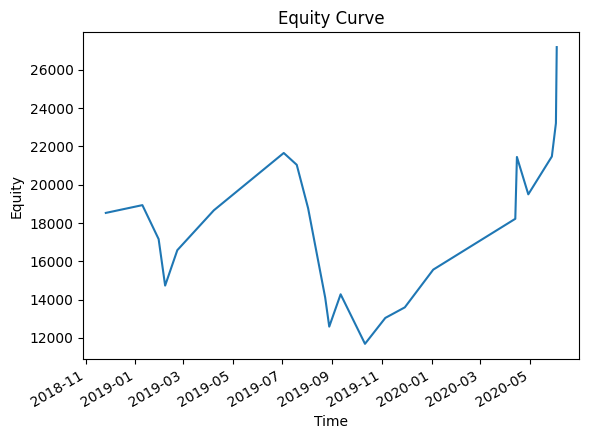

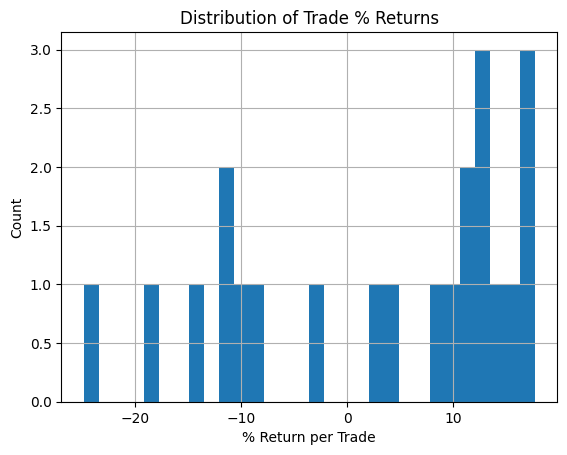

In [115]:
# Equity curve
if not trades_df.empty:
    start_eq = (initial_equity / max(1, len(trades_df['symbol'].unique())))
    eq = [start_eq]
    times = []
    for _, r in trades_df.sort_values('exit_time').iterrows():
        eq.append(eq[-1] * (1 + r['gross_ret_pct']/100.0))
        times.append(r['exit_time'])
    equity_series = pd.Series(eq[1:], index=pd.to_datetime(times))

    plt.figure()
    equity_series.plot()
    plt.title("Equity Curve")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.show()

    # Trade % return distribution
    plt.figure()
    (trades_df['gross_ret_pct']).hist(bins=30)
    plt.title("Distribution of Trade % Returns")
    plt.xlabel("% Return per Trade")
    plt.ylabel("Count")
    plt.show()